In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import pandas as pd
import sys 
sys.path.append("../../")
from src.model import ddsm as ddsm
from src.model import ddsm_model as modeld
from src.model.lightning_model_diffusion import LightningDiffusion as lightning_dif
import src.utils.sequence as utils

import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline
# import wandb # This is optional 
# wandb.login(host = "https://genentech.wandb.io" )

/data/yulai/anaconda3/envs/grelu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load pre-trained model 

In [2]:
class ModelParameters:
    diffusion_weights_file = 'artifacts/DNA-dataset:v0/steps400.cat4.speed_balance.time4.0.samples100000.pth'
    checkpoint_path = '../../save_models/ATAC/Hepg2_10class_V1/_2024.09.11_03.01.28/diffusion_epoch=479-average-loss=0.285.ckpt'
    time_schedule = 'artifacts/DNA-dataset:v0/time_dependent.npz'
config = ModelParameters() 

DEVICE = "cuda:3"

In [3]:
# Load Reward model
from grelu.lightning import LightningModel

reward_model = LightningModel.load_from_checkpoint("artifacts/binary_atac_reward_model.ckpt")
reward_model.eval()
reward_model.to(DEVICE)

/data/yulai/anaconda3/envs/grelu/lib/python3.9/site-packages/enformer_pytorch/modeling_enformer.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  TF_GAMMAS = torch.load(s

LightningModel(
  (model): EnformerPretrainedModel(
    (embedding): EnformerTrunk(
      (conv_tower): EnformerConvTower(
        (blocks): ModuleList(
          (0): Sequential(
            (0): Conv1d(4, 768, kernel_size=(15,), stride=(1,), padding=same)
            (1): ConvBlock(
              (norm): Norm(
                (layer): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (conv): Conv1d(768, 768, kernel_size=(1,), stride=(1,), padding=same)
              (act): Activation(
                (layer): GELU()
              )
              (pool): Pool(
                (layer): AttentionPool(
                  (pool_fn): Rearrange('b d (n p) -> b d n p', p=2)
                  (to_attn_logits): Conv2d(768, 768, kernel_size=(1, 1), stride=(1, 1), bias=False)
                )
              )
              (dropout): Dropout(
                (layer): Identity()
              )
              (channel_transform): ChannelT

In [4]:
# Introduce Two Models

# original_model = lightning_dif.load_from_checkpoint(
#         checkpoint_path=config.checkpoint_path, 
#         weight_file=config.diffusion_weights_file, 
#         time_schedule=config.time_schedule, 
#         all_class_number=3,
#         continuous=False
#     )

original_model = lightning_dif.load_from_checkpoint(
        checkpoint_path=config.checkpoint_path, 
        weight_file=config.diffusion_weights_file, 
        time_schedule=config.time_schedule, 
        augment=False,
        continuous=False,
        all_class_number=10,
    )

original_model = original_model.model
original_model.cuda(device = DEVICE)

/data/yulai/projects/RLfinetuning_Diffusion_Bioseq/tutorials/Human-enhancer/../../src/model/lightning_model_diffusion.py:29: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


AugmentedScoreNet_Conditional(
  (embed): Sequential(
    (0): GaussianFourierProjection()
    (1): Linear(in_features=256, out_features=256, bias=True)
  )
  (linear): Conv1d(4, 256, kernel_size=(9,), stride=(1,), padding=(4,))
  (blocks): ModuleList(
    (0-1): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (2): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
    (3): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
    (4): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    (5-6): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (7): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
    (8): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
    (9): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    (10-11): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), 

# Evaluation 

In [23]:
### Get Samples from Pre-Trained Models 

sampler = ddsm.Euler_Maruyama_sampler
strength = 2

# Create conditions for 10 classes
conditions = [torch.tensor([i,] * 128, device=DEVICE, dtype=torch.long) for i in range(10)]

# Initialize lists to hold samples for all 10 classes
allsamples_original_conditions = [[] for _ in range(10)]

# Original model needs to be in evaluation mode
original_model.eval()

# Loop through 10 classes
for class_num in range(10):
    condition = conditions[class_num]
    for t in range(10):
        samples = []
        samples.append(sampler(original_model,
                               (200, 4),
                               existing_condition=condition,
                               class_number=10,  # Use 10 classes
                               strength=strength,
                               batch_size=128,
                               max_time=4.0,
                               min_time=1.0/400,
                               time_dilation=1,
                               num_steps=100,
                               eps=1e-5,
                               speed_balanced=True,
                               device=DEVICE,
                               augment=False
                               ).cpu().detach().numpy())
        allsamples_original_conditions[class_num].append(samples)

# Concatenate samples for each class
allsamples_conditions = [np.concatenate(allsamples_original_conditions[i], axis=1)[0, :, :, :] for i in range(10)]

In [24]:
# Function to calculate rewards for each condition
def calculate_rewards(samples_condition):
    rewards = []
    data_loader = torch.utils.data.DataLoader(
        samples_condition.astype("float32"), 
        batch_size=128, 
        num_workers=0
    )
    for batch in data_loader:
        batch = (batch > 0.5) * torch.ones_like(batch)
        batch = torch.permute(batch, (0, 2, 1)).to(DEVICE)
        rewards.append(reward_model(batch).detach().cpu())
    
    return np.concatenate(rewards)

(12800,)


/tmp/ipykernel_504284/626676649.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=plot_data,


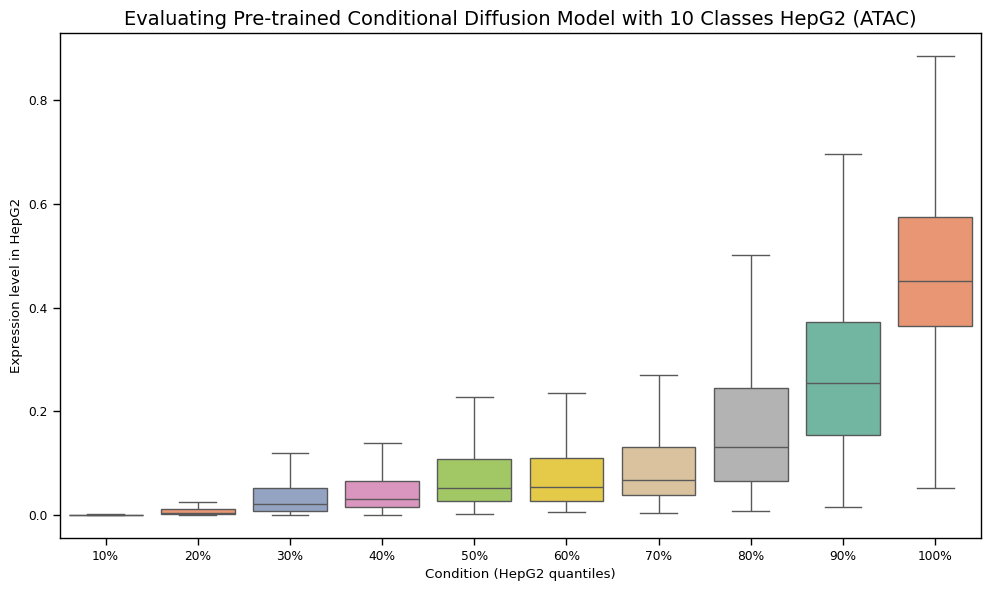

In [25]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate rewards for each condition
rewards_conditions = [calculate_rewards(allsamples_conditions[i]) for i in range(10)]

# Prepare data for comparison and plotting
compare_hepg2 = np.concatenate([rewards_conditions[i][:, 1].reshape(-1) for i in range(10)], axis=0)
types = [f'{(i+1)*10}%' for i in range(10)]
types_flat = [t for i, t in enumerate(types) for _ in range(len(rewards_conditions[i][:, 1]))]

print(compare_hepg2.shape)

data_dict = {'Condition (HepG2 quantiles)': types_flat, 'Expression level in HepG2': compare_hepg2}
plot_data = pd.DataFrame(data_dict)

# Plotting
sns.set_context("paper")

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=plot_data, 
                 x='Condition (HepG2 quantiles)', 
                 y='Expression level in HepG2',
                 palette="Set2",
                 showfliers=False)  # Disable plotting of outliers

# Add title and adjust layout
plt.title('Evaluating Pre-trained Conditional Diffusion Model with 10 Classes HepG2 (ATAC)', fontsize=14)
plt.tight_layout()

# Save the figure
plt.savefig(f"../../media/ATAC/Eval_pre-trained-model_strength={strength}_hepg2-10class-boxplot-final.png")

plt.show()